In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [26]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [27]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [28]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [285]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


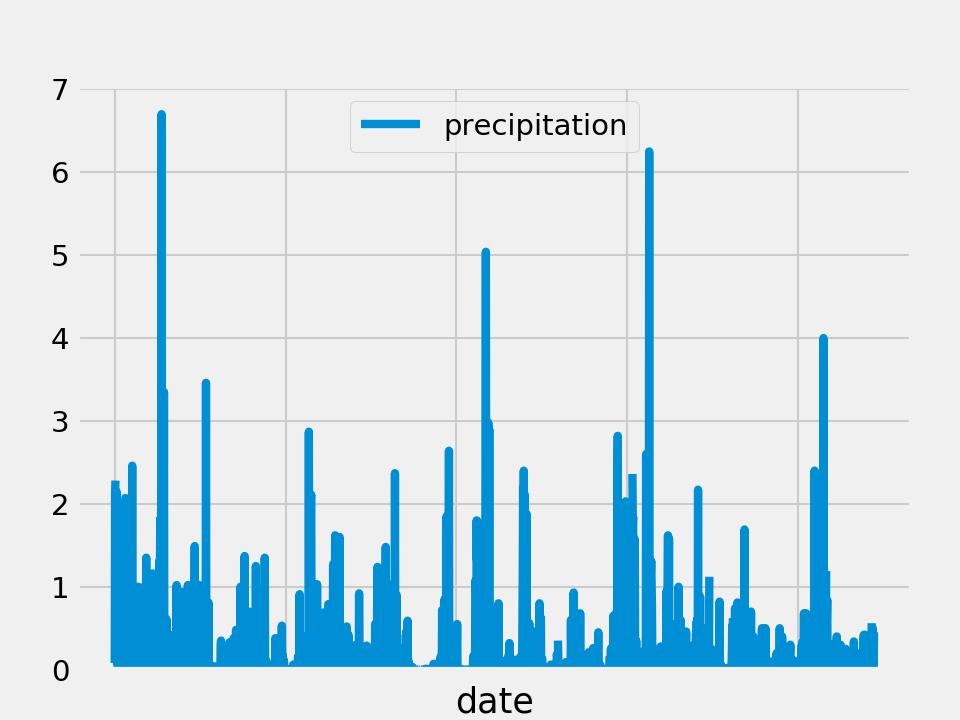

In [156]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
# Not 12 months of data from 1 year ago, instead doing from last date
last_dt = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
twelvemdt =  dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
twelvem = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > twelvemdt).\
    order_by(Measurement.date).all()
date = session.query(Measurement.date).\
    filter(Measurement.date > twelvemdt).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcpdf = pd.DataFrame(twelvem)
prcpdf["precipitation"]=prcpdf["prcp"]
prcpdf = prcpdf.drop(columns = ['prcp'])
prcpdf.set_index("date", inplace=True, drop=True)
prcpdf['precipitation'].max()
# Sort the dataframe by date
#prcpdf.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
prcpdf.plot()
# Rotate the xticks for the dates
#plt.xticklabels(prcpdf['date'])
plt.xticks(rotation = 70)
plt.show()

In [157]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdf.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [168]:
# How many stations are available in this dataset?
station = []
for value in session.query(Measurement.station).distinct():
     station.append(value)
len(station)

9

In [178]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [181]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


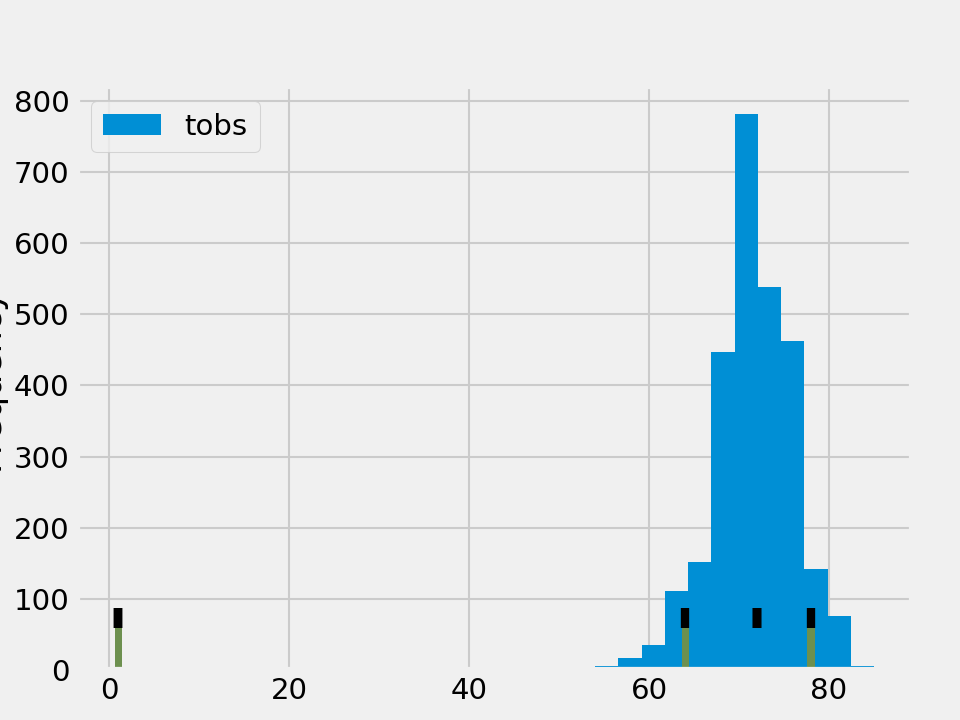

In [219]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp_Ob_Freq = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').all()
Temp_df = pd.DataFrame(Temp_Ob_Freq)
Temp_df.plot(kind = 'hist', bins = 12, legend = True)
plt.show()

In [220]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [239]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_y = calc_temps('2017-02-28', '2017-03-05')
Min, Avg, Max = prev_y[0]

64.0

<IPython.core.display.Javascript object>


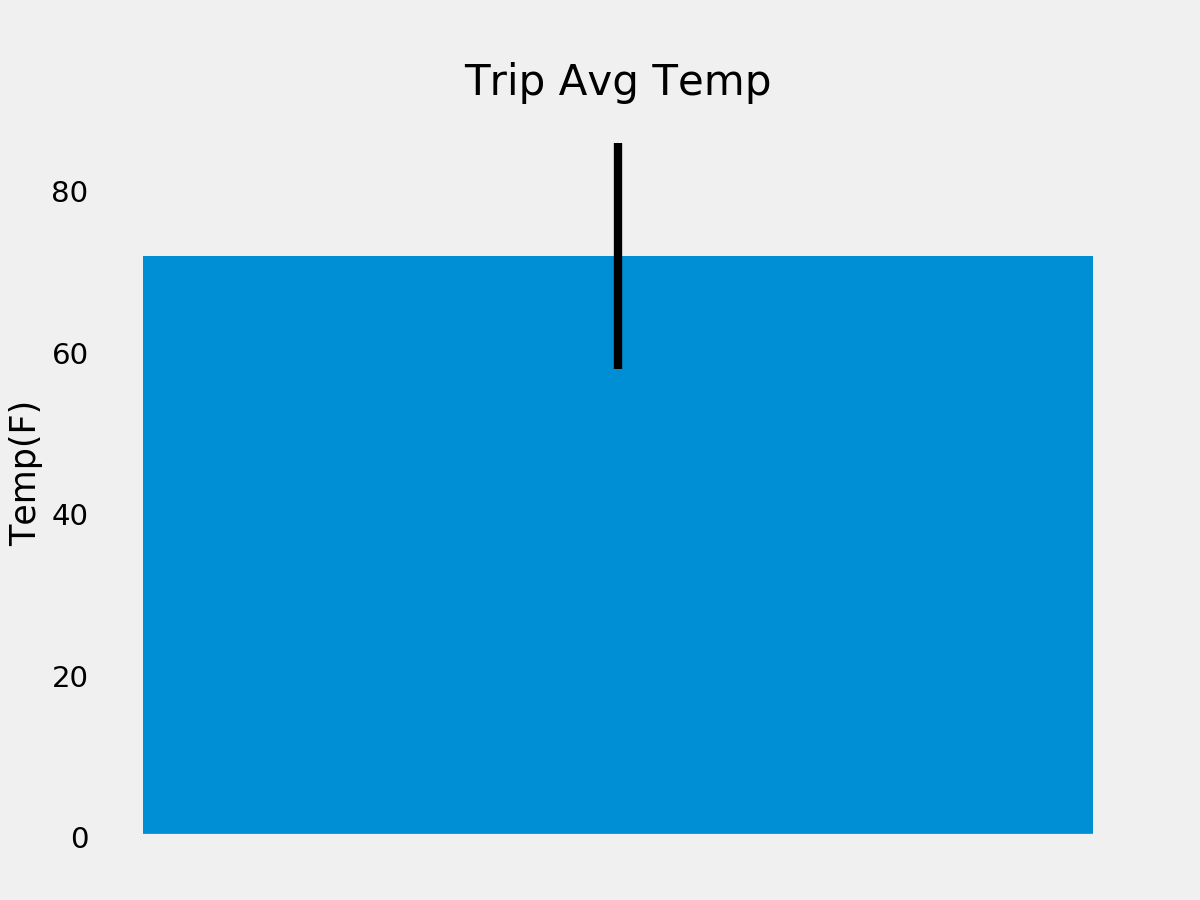

In [283]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(1, Avg, yerr=Min-Max)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
plt.grid()
plt.show()

In [350]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.prcp, Measurement.station, Station.latitude, Station.longitude, Station.elevation).\
    filter(Station.station == Measurement.station, Measurement.date == '2016-10-23').\
    order_by(Measurement.prcp.desc()).all()

[(0.24, 'USC00516128', 21.3331, -157.8025, 152.4),
 (0.02, 'USC00519281', 21.45167, -157.84888999999998, 32.9),
 (0.01, 'USC00519397', 21.2716, -157.8168, 3.0),
 (0.01, 'USC00513117', 21.4234, -157.8015, 14.6),
 (0.0, 'USC00519523', 21.33556, -157.71139, 19.5),
 (None, 'USC00514830', 21.5213, -157.8374, 7.0)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


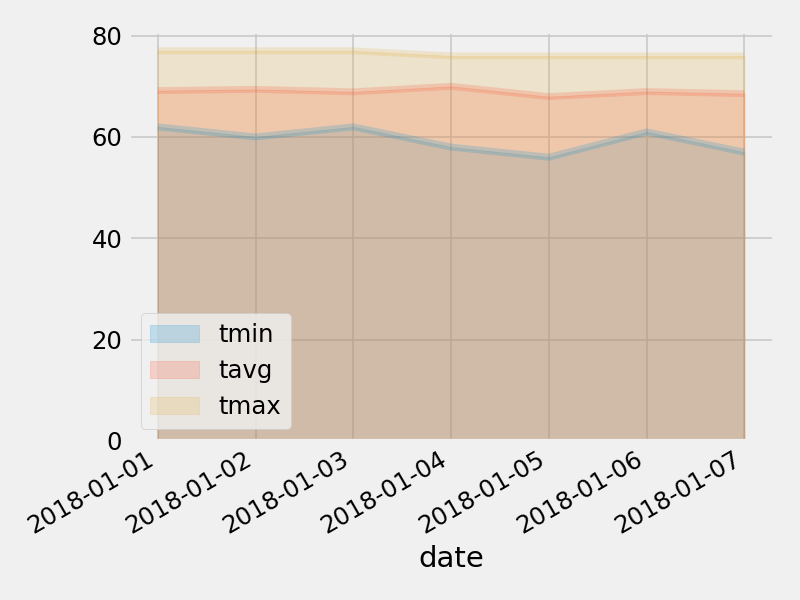

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
